In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve
import starry

In [3]:
# Degree of the Ylm expansion
lmax = 20
N = (lmax + 1) ** 2

In [4]:
# Grab the `A1` matrix from `starry`
map = starry.Map(lmax, lazy=False)
A1 = map.ops.A1.eval()

In [34]:
def Ij(j, x):
    """
    
    """
    if j == 0:
        return 0.5 * np.pi * (1 - x ** 2)
    else:
        return (j - 1) / (j + 2) * (1 - x ** 2) * Ij(j - 2, x)

    
def sn(n, D, wsini_c):
    """
    
    """
    # This is a vector function!
    D = np.atleast_1d(D)
    res = np.zeros_like(D)
    
    # Indices
    LAM = np.floor(np.sqrt(n))
    DEL = 0.5 * (n - LAM ** 2)
    i = int(np.floor(LAM - DEL))
    j = int(np.floor(DEL))
    k = int(np.ceil(DEL) - np.floor(DEL))
    
    # x coordinate of lines of constant Doppler shift
    x = (1 / wsini_c) * (np.exp(2 * D) - 1) / (np.exp(2 * D) + 1)

    # Integral is only nonzero when we're
    # inside the unit disk
    idx = np.abs(x) < 1
    
    # Solve the integral
    if (k == 0) and (j % 2 == 0):
        res[idx] = (2 * x[idx] ** i * (1 - x[idx] ** 2) ** (0.5 * (j + 1))) / (j + 1)
    elif (k == 1) and (j % 2 == 0):
        res[idx] = x[idx] ** i * Ij(j, x[idx])
    
    return res


def s(D, wsini_c):
    """
    
    """
    res = np.zeros((N, len(D)))
    for n in range(N):
        res[n] = sn(n, D, wsini_c)
    return res


def g(D, wsini_c):
    """
    
    """
    # A1 is a sparse scipy matrix, so `*` 
    # is actually how we dot matrices!
    return s(D, wsini_c).T * A1

In [24]:
# Compute the Ylm expansion of a Gaussian spot
map.reset()
map.add_spot(amp=-0.1, sigma=0.05, lat=30)
ylm = np.array(map.y)

# Check that the specific intensity is positive everywhere
assert np.nanmin(map.render()) > 0

# Show the star
map.show(theta=np.linspace(0, 360, 50))

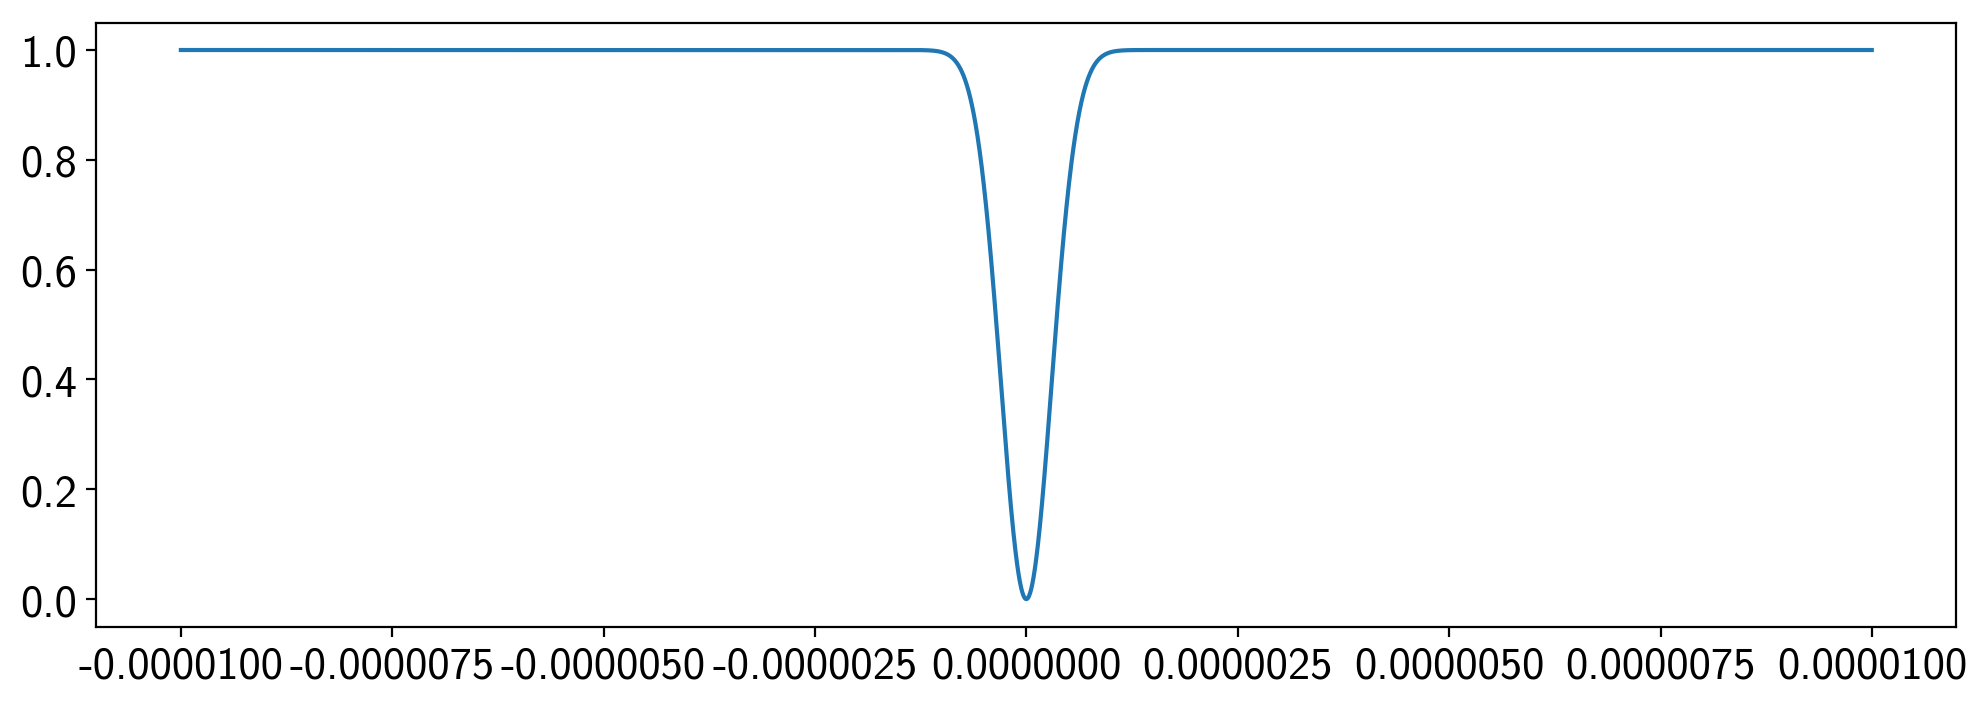

In [61]:
# Log wavelength array
xi = np.linspace(-2e-5, 2e-5, 9999)
dxi = xi[1] - xi[0]
obs = np.abs(xi) < 1e-5

# A gaussian absorption line
amp = 1.0
mu = 0.0
sigma = 3e-7
a0 = 1 - amp * np.exp(-0.5 * (xi - mu) ** 2 / sigma ** 2)

plt.plot(xi[obs], a0[obs]);

In [62]:
wsini_c = 2.0e-6
maxD = 0.5 * np.log((1 + wsini_c) / (1 - wsini_c))
D = xi[(xi >= -maxD) & (xi <= maxD)]
# NOTE: In starry, the z axis points *toward* the observer!
G = g(D, -wsini_c)

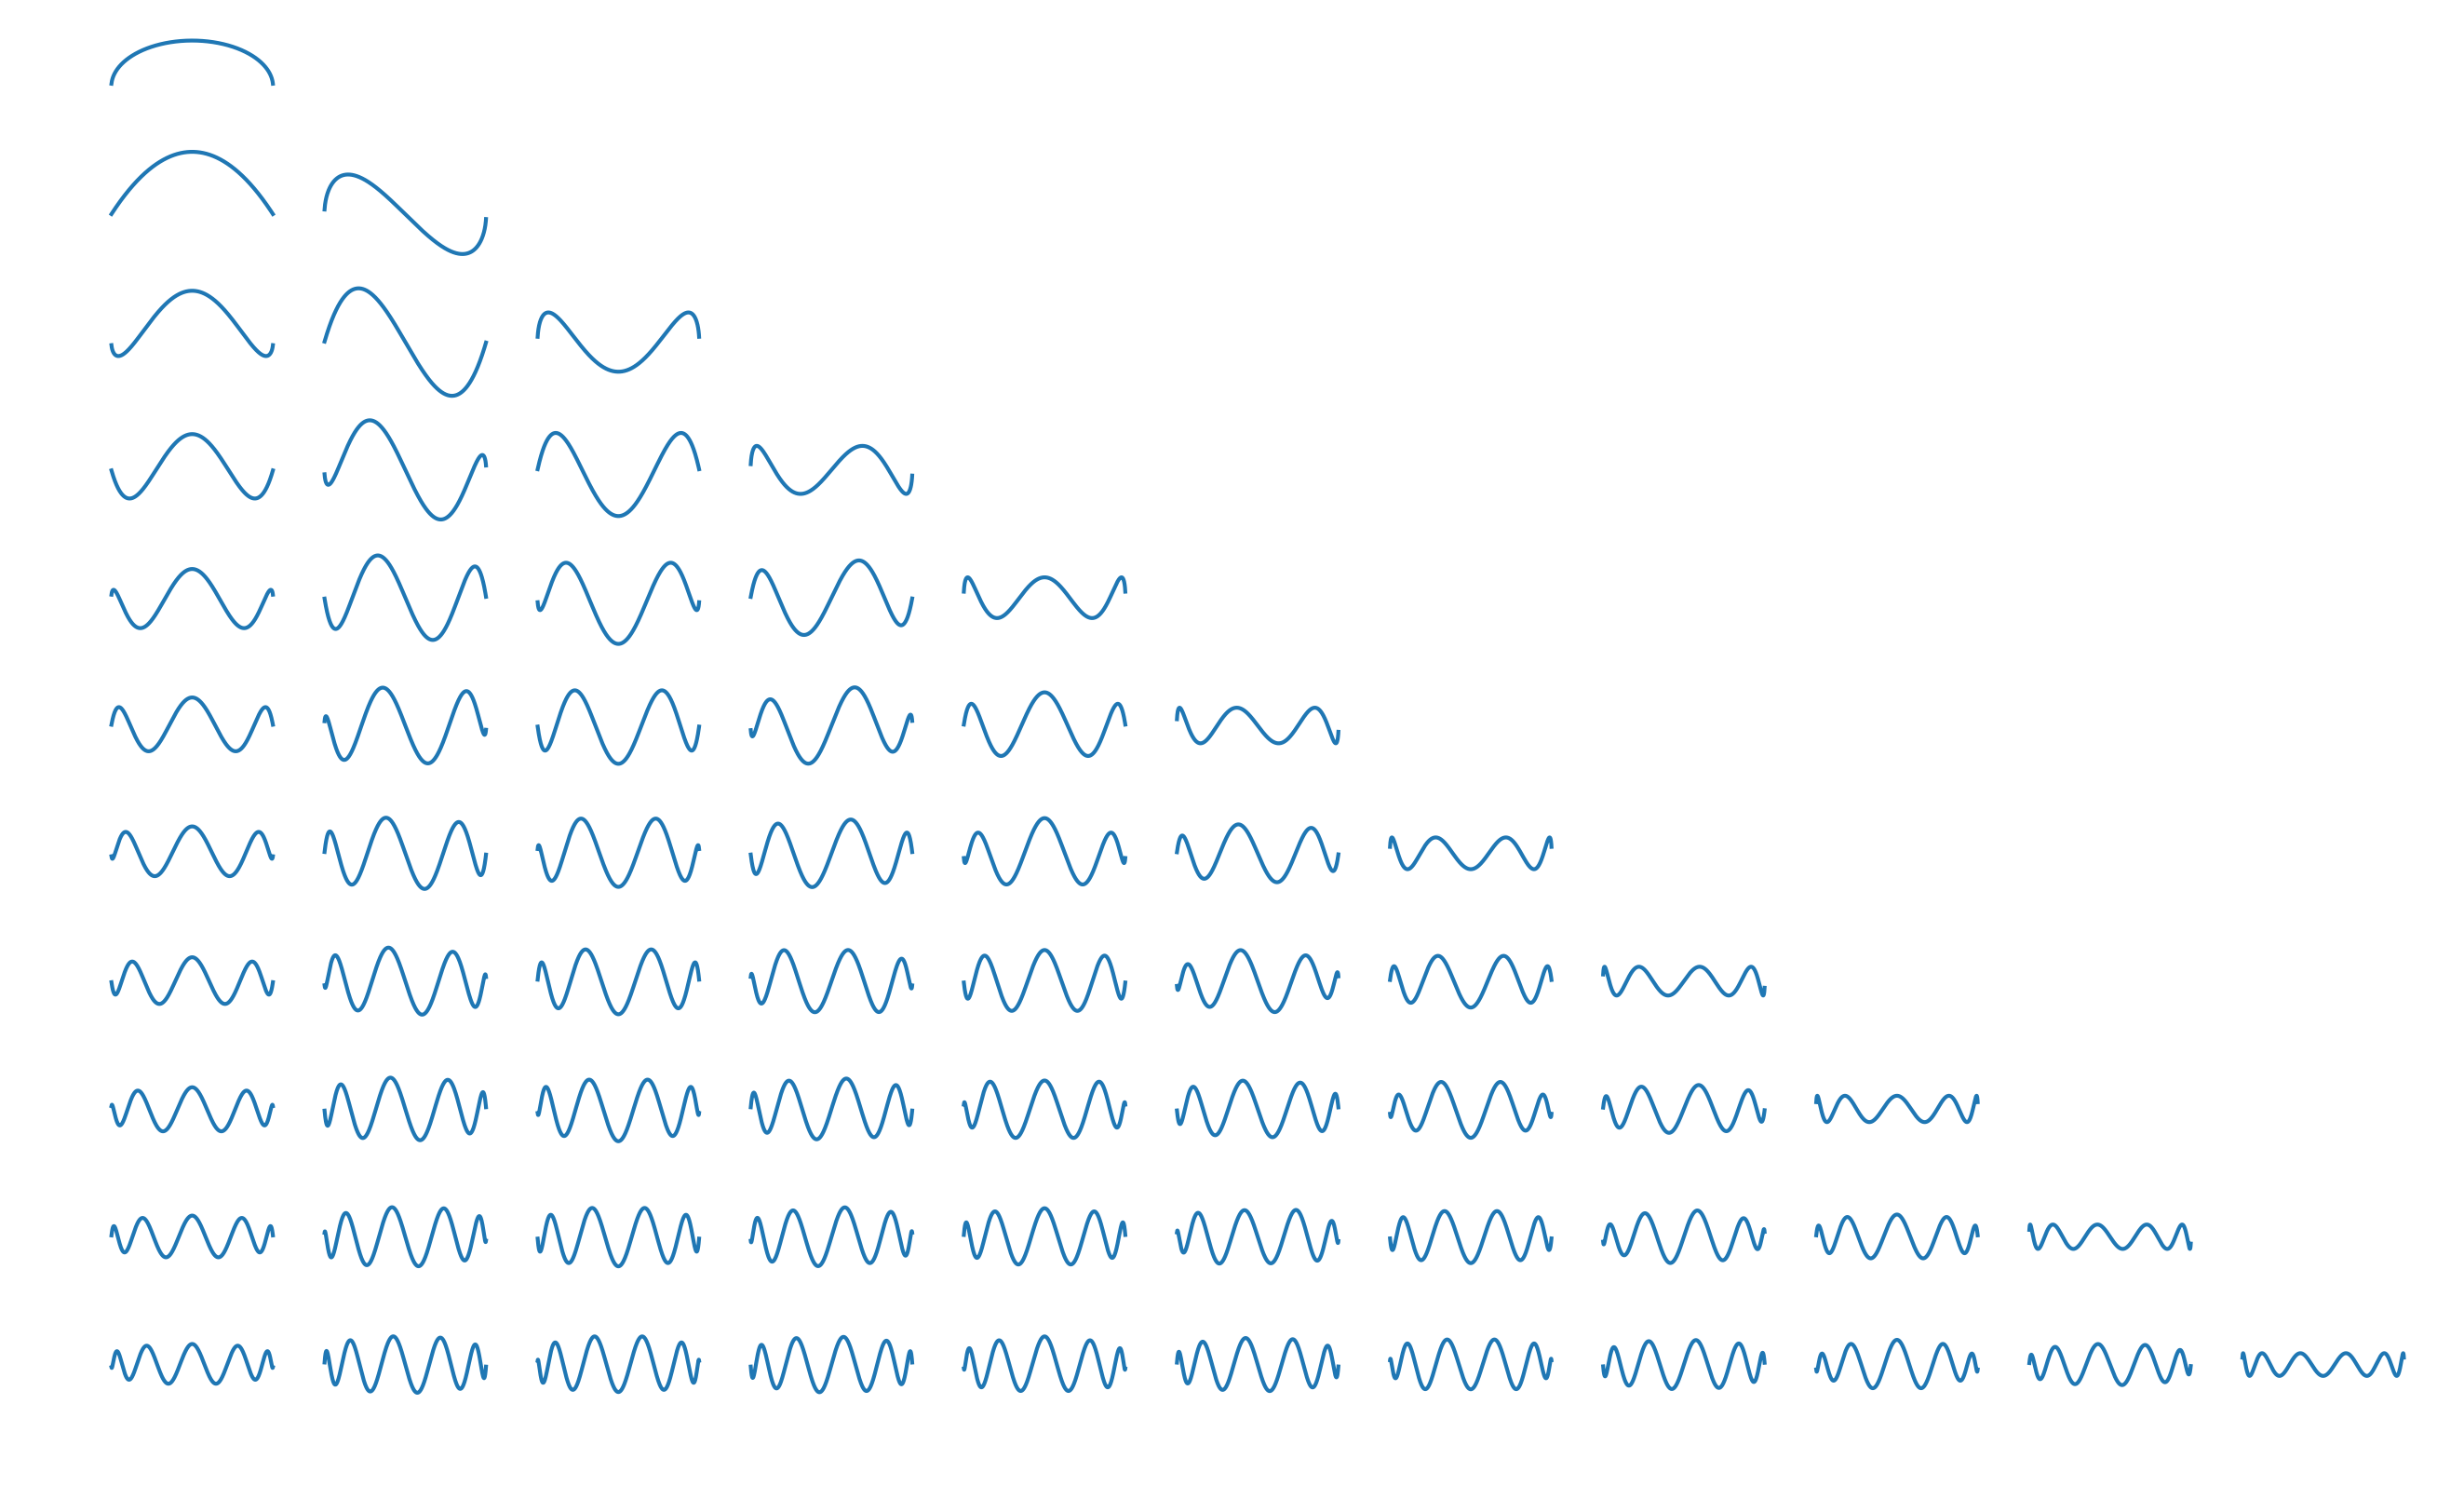

In [63]:
# Set up the plot
ydeg = 10
fig, ax = plt.subplots(ydeg + 1, ydeg + 1, figsize=(16, 10), 
                       sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
for axis in ax.flatten():
    axis.axis('off')

# Loop over the orders and degrees
n = 0
for i, l in enumerate(range(ydeg + 1)):
    # Skip the odd orders
    n += l
    # Plot the even orders
    for j, m in enumerate(range(0, l + 1)):
        ax[i, j].plot(G[:, n])
        n += 1

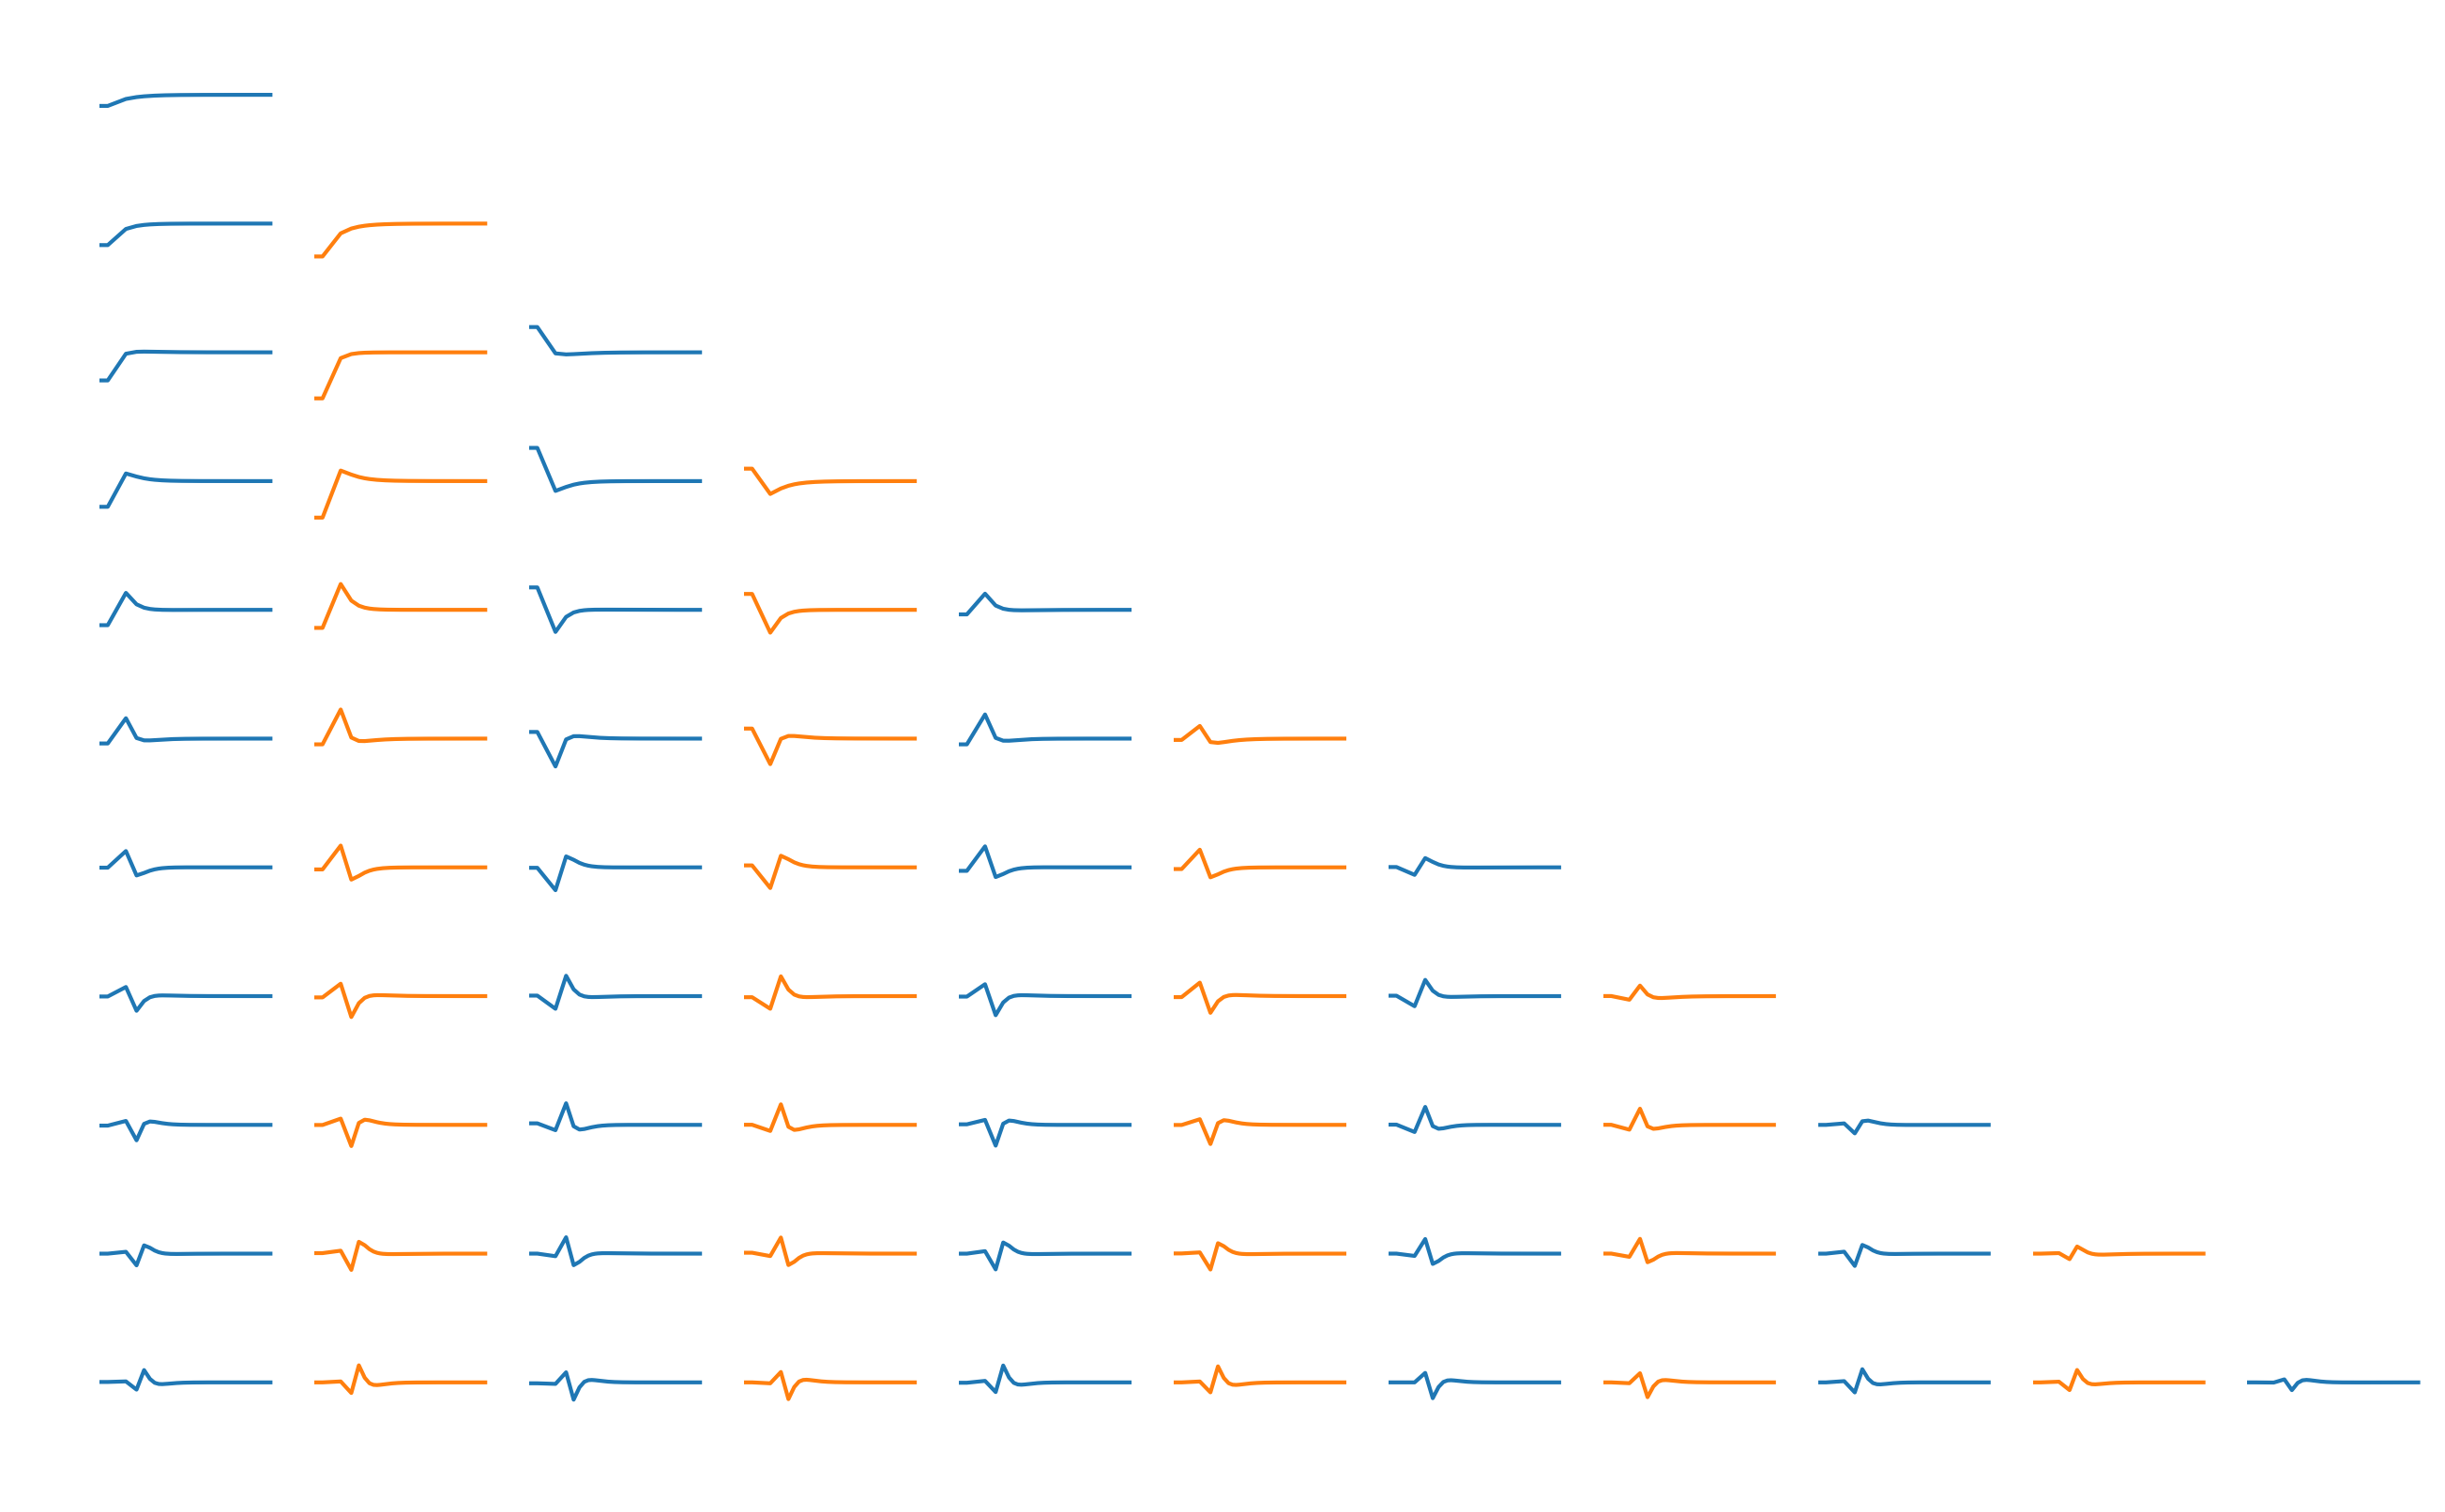

In [75]:
# Set up the plot
ydeg = 10
fig, ax = plt.subplots(ydeg + 1, ydeg + 1, figsize=(16, 10), 
                       sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
for axis in ax.flatten():
    axis.axis('off')

# Loop over the orders and degrees
n = 0
for i, l in enumerate(range(ydeg + 1)):
    # Skip the odd orders
    n += l
    # Plot the even orders
    for j, m in enumerate(range(0, l + 1)):
        fG = np.fft.rfft(G[:, n])
        k = np.fft.rfftfreq(len(D), D[1] - D[0])
        if m % 2 == 0:
            ax[i, j].plot(k, fG.real, color="C0")
        else:
            ax[i, j].plot(k, fG.imag, color="C1")
        ax[i, j].set_xscale("log")
        n += 1

## Time evolution

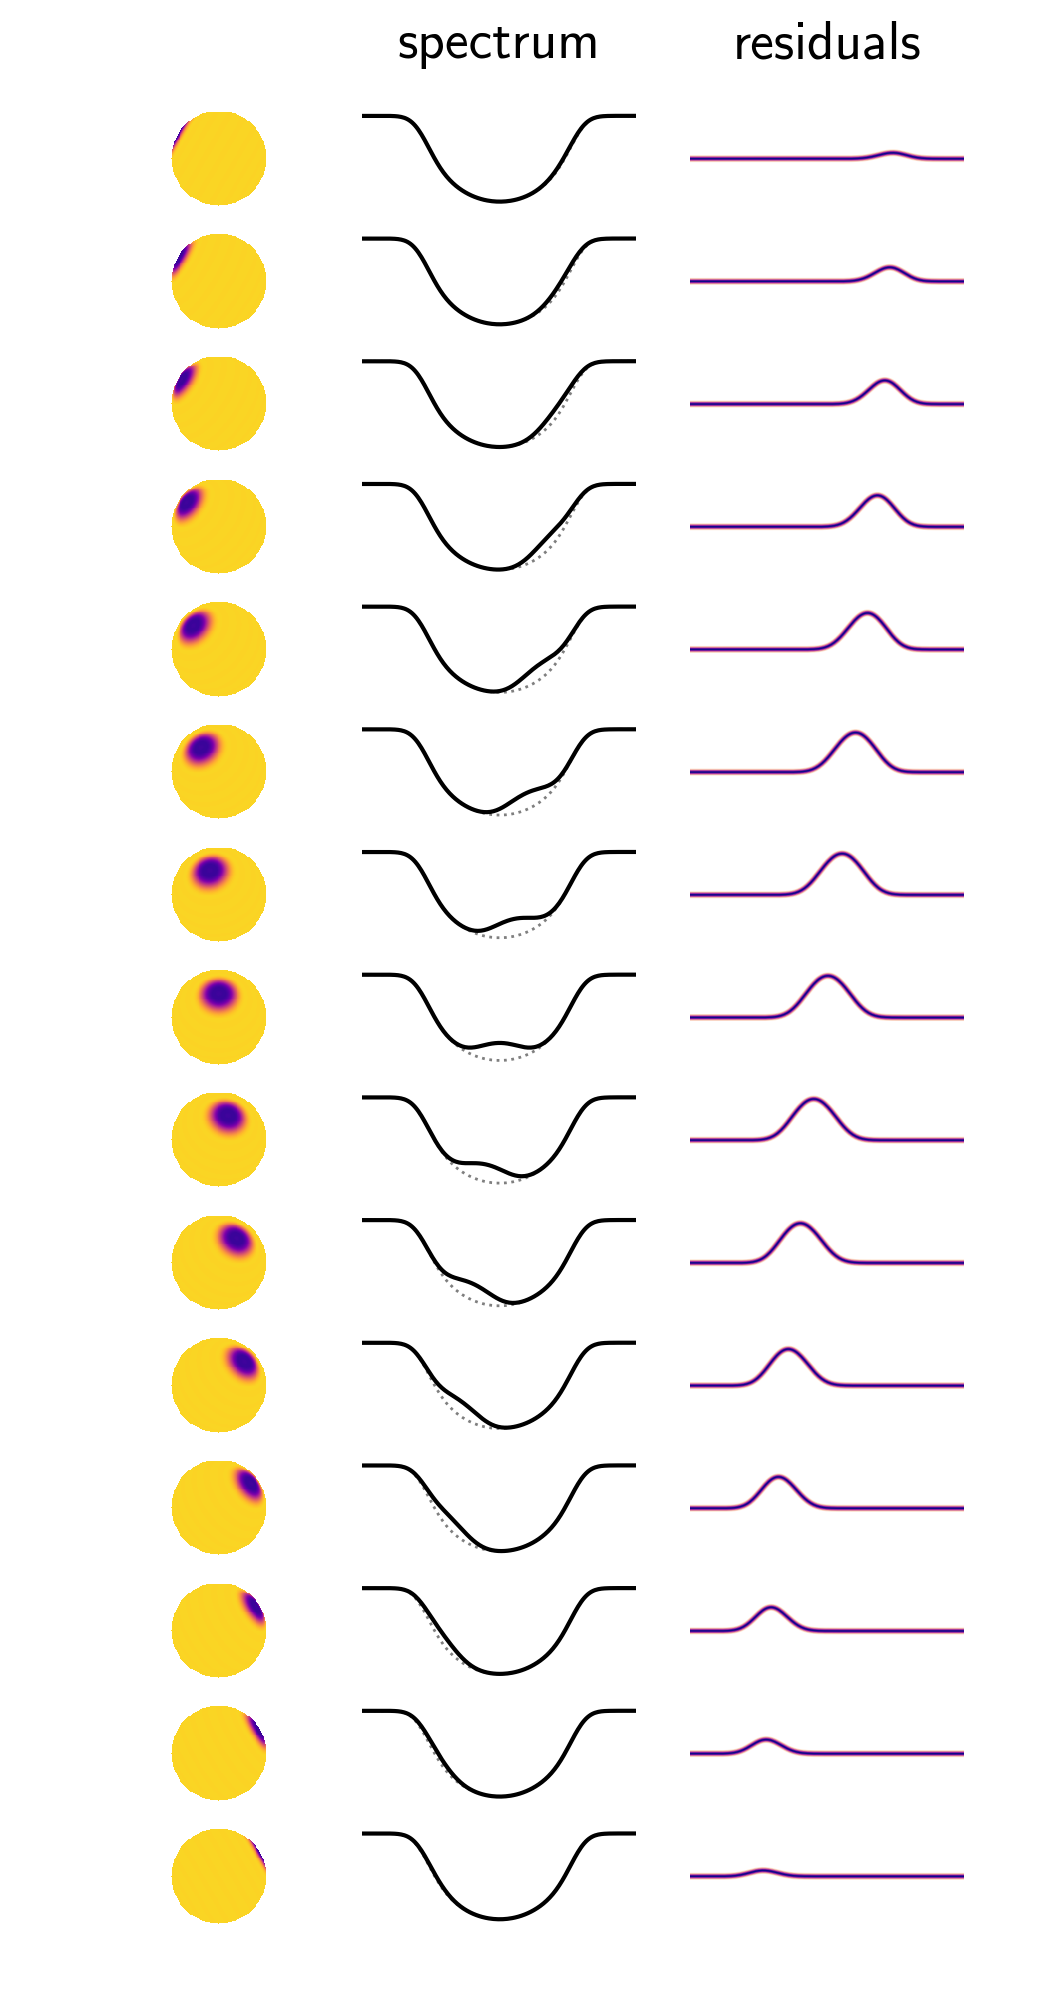

In [38]:
# Get vmin, vmax
map[1:, :] = ylm[1:]
img = map.render()
vmin = np.nanmin(img)
vmax = np.nanmax(img)
rng = vmax - vmin
vmin -= 0.1 * rng
vmax += 0.1 * rng

# Compute the spectrum when the spot is on 
# the backside for reference
map.rotate(180)
a = np.dot(map.y.reshape(-1, 1), a0.reshape(1, -1))
S0 = np.zeros_like(xi)
for n in range(N):
    S0 += convolve(a[n], G[:, n], mode="same")
S0 -= S0[obs][0]

# Let's do it
nt = 15
theta = np.linspace(-90, 90, nt)
fig, ax = plt.subplots(nt, 3, figsize=(6, 12))
fig.subplots_adjust(hspace=0.3)
cmap = plt.get_cmap("plasma")

for t in range(nt):
    # Rotate & compute spectrum
    map[1:, :] = ylm[1:]
    map.rotate(theta[t])
    a = np.dot(map.y.reshape(-1, 1), a0.reshape(1, -1))
    S = np.zeros_like(xi)
    for n in range(N):
        S += convolve(a[n], G[:, n], mode="same")
    S -= S[obs][0]
    
    # Plot spectrum
    ax[t, 1].plot(xi[obs], S0[obs], "k:", lw=1, alpha=0.5)
    ax[t, 1].plot(xi[obs], S[obs], "k-")
    ax[t, 1].set_xlim(-0.0000035, 0.0000035)
    ax[t, 1].axis('off');
    
    # Plot residuals
    color = [cmap(x) for x in np.linspace(0.75, 0.0, 5)]
    lw = np.linspace(2.5, 0.5, 5)
    alpha = np.linspace(0.25, 1, 5)
    for i in range(5):
        ax[t, 2].plot(xi[obs], S[obs] - S0[obs], ls="-", 
                      lw=lw[i], color=color[i], alpha=alpha[i])
    
    ax[t, 2].set_xlim(-0.0000035, 0.0000035)
    ax[t, 2].axis('off');
    ax[t, 2].set_ylim(-2.8, 2.8)
    
    # Plot current stellar image
    img = map.render(res=100)[:, :, 0]
    ax[t, 0].imshow(img, origin="lower", 
                    extent=(-1, 1, -1, 1),
                    cmap=cmap, vmin=vmin,
                    vmax=vmax)
    ax[t, 0].set_xlim(-3, 1)
    ax[t, 0].set_ylim(-1, 1)
    ax[t, 0].axis('off');

ax[0, 1].set_title("spectrum", y=1.4);
ax[0, 2].set_title("residuals", y=1.4);

## Compare to numerical

In [39]:
# Get the map image at a given phase
map.reset()
map.add_spot(amp=-0.1, sigma=0.05, lat=30, lon=30)
alm = np.array(map.y)

In [50]:
# Define a base spectrum
xi = np.linspace(-5e-5, 5e-5, 9999)
dxi = xi[1] - xi[0]
obs = np.abs(xi) < 2e-5
amp = 1.0
mu = 0.0
sigma = 3e-7
I0 = 1 - amp * np.exp(-0.5 * (xi - mu) ** 2 / sigma ** 2)

In [51]:
# The equatorial angular velocity
wsini_c = 2.0e-6

In [52]:
# Starry
mmaxD = np.log(1 + wsini_c)
D = xi[(xi >= -maxD) & (xi <= maxD)]
G = g(D, -wsini_c)
a = np.dot(alm.reshape(-1, 1), I0.reshape(1, -1))
S = np.zeros_like(xi)
for n in range(N):
    S += convolve(a[n], G[:, n], mode="same")
S /= S[obs][0]

In [53]:
# Numerical
res_arr = [100, 300] #, 600]
Snum = [None for i in range(len(res_arr))]
for i, res in enumerate(res_arr):
    image = np.tile(map.render(res=res).reshape(-1, 1), len(xi))
    x, y, z = map.ops.compute_ortho_grid(res).eval()
    D = 0.5 * np.log((1 + wsini_c * x) / (1 - wsini_c * x))
    spec = np.interp(xi + D.reshape(-1, 1), xi, I0)
    Snum[i] = np.nansum(image * spec, axis=0)
    Snum[i] /= Snum[i][0]

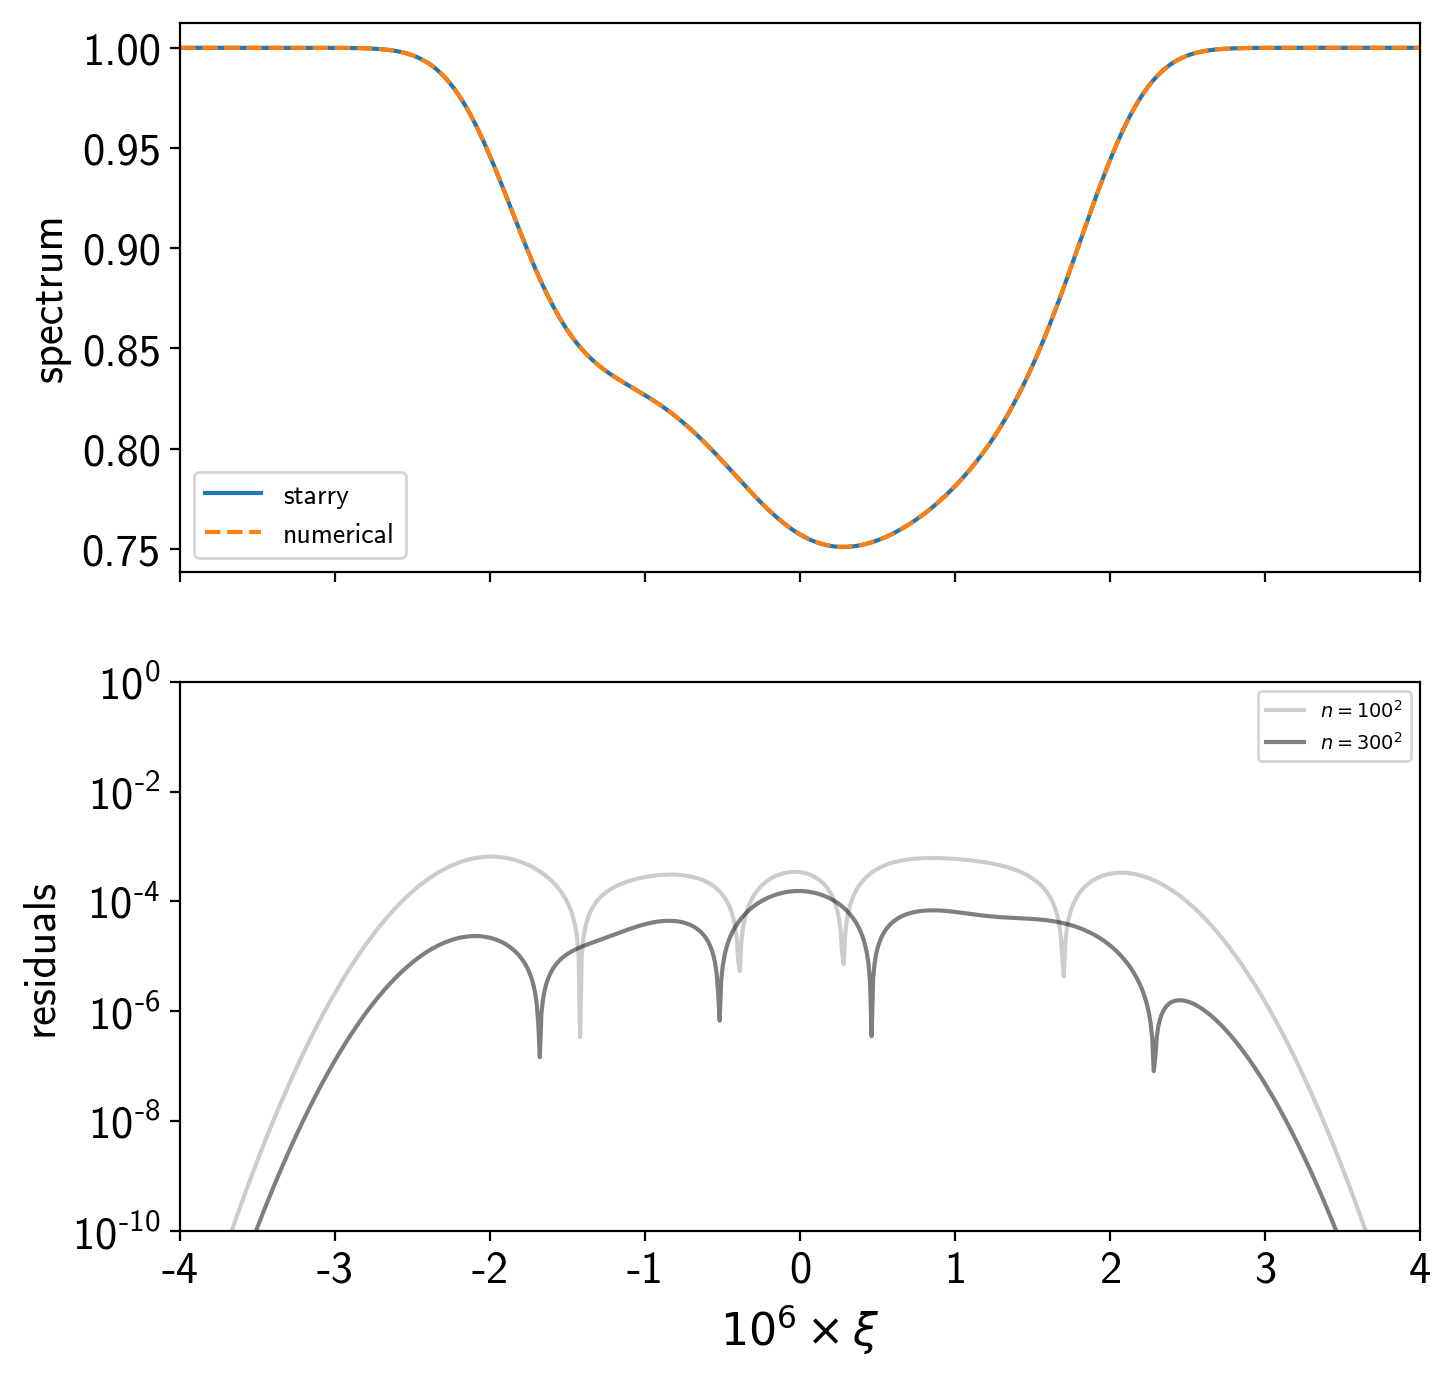

In [54]:
# Compare
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 8))
ax[0].plot(1e6 * xi[obs], S[obs], label="starry")
ax[0].plot(1e6 * xi[obs], Snum[-1][obs], "--", label="numerical");
ax[0].set_xlim(-4, 4)
alpha = [0.2, 0.5, 1.0]
for i in range(len(Snum)):
    ax[1].plot(1e6 * xi[obs], np.abs(S[obs] - Snum[i][obs]), 
               label=r"$n = %d^2$" %res_arr[i], color="k", alpha=alpha[i]);

# DEBUG: High wavelength res numerical
"""
xi_hr = np.linspace(-5e-5, 5e-5, 999)
dxi_hr = xi_hr[1] - xi_hr[0]
obs_hr = np.abs(xi_hr) < 2e-5
I0_hr = 1 - amp * np.exp(-0.5 * (xi_hr - mu) ** 2 / sigma ** 2)
res_hr = 300
image_hr = np.tile(map.render(res=res_hr).reshape(-1, 1), len(xi_hr))
x_hr, y_hr, z_hr = map.ops.compute_ortho_grid(res_hr).eval()
alpha_hr = np.log(1 - wsini * x_hr / c)
spec_hr = np.interp(xi_hr + alpha_hr.reshape(-1, 1), xi_hr, I0_hr)
Snum_hr = np.nansum(image_hr * spec_hr, axis=0)
Snum_hr /= Snum_hr[0]
ax[0].plot(1e6 * xi_hr[obs_hr], Snum_hr[obs_hr], "k-", zorder=-3, lw=2, alpha=0.5);
"""
    
ax[0].set_ylabel(r"spectrum")
ax[0].legend(fontsize=10)
ax[1].set_yscale("log")
ax[1].set_xlabel(r"$10^{6}\times\xi$");
ax[1].legend(fontsize=7)
ax[1].set_ylim(1e-10, 1e0);
ax[1].set_ylabel(r"residuals");